# Banglore home prices analysis

### A simple end to end project:

- Data cleaning and formating
- Exploratory analysis
- Feature engineering and imputation
- Model training and evaluation
- Build a web server with Flask that consumes predictions from the trained model, and a UI (client) with css, html, and js that makes http POST and GET calls to the web server
- Similar to the Zillow Zestimate feature

In [ ]:
import sys
import os
from pathlib import Path

'''data'''
import pandas as pd
import numpy as np

'''visualization'''
import matplotlib.pyplot as plt

'''sklearn'''
from sklearn.model_selection import ShuffleSplit

'''models'''
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

'''performance evaluation'''
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

import joblib

In [ ]:
# Set working directory 
try: INIT_RUN
except NameError:
    os.chdir(os.path.dirname(os.getcwd()))
    INIT_RUN=True

In [ ]:
'''custom module'''
from home_price_analysis.config.core import (
    config,
    PROCESSED_DATA_DIR,
    TRAINED_MODEL_DIR)
from home_price_analysis.processing import (
    data_manager as dm,
    features as pp,
    model_helpers as helpers
)
from home_price_analysis.pipeline import price_pipeline
from home_price_analysis import __version__

## Import data

In [ ]:
raw = dm.load_dataset(file_name=config.app_config.RAW_DATA_FILE)

## Train test split

In [ ]:
# init the split object
split = ShuffleSplit(n_splits=1,
                     test_size=config.model_config.TEST_SIZE,
                     random_state=config.model_config.RANDOM_STATE)

In [ ]:
# Only 1 fold was done since set "n_splits" to 1.
# We shuffle the overall dataset, and then draw 0.8 of the sample to the train set and 0.2 to the test set
for train_index, test_index in split.split(X=raw):
   # We only have one set of train and test index since we only have 1 fold
    train_set = raw.loc[train_index]
    test_set = raw.loc[test_index]

In [ ]:
# Perform data preprocessing for size and total_sqft separately for the train and test set
train_set = dm.preprocess_data(train_set)
test_set = dm.preprocess_data(test_set)

In [ ]:
# separate out the features dataframe and outcome series
X_train = train_set[config.model_config.FEATURES]
X_test = test_set[config.model_config.FEATURES]

y_train = np.log(train_set[config.model_config.OUTCOME_VARIABLE])
y_test = np.log(test_set[config.model_config.OUTCOME_VARIABLE])

## Data Processing

In [ ]:
# Fit pipeline to train data
tf = price_pipeline.fit(X_train,y_train)

In [ ]:
# Transform the train and test datasets
X_train = tf.transform(X_train)
X_test = tf.transform(X_test)

In [ ]:
# save the column names of the processed X_train data
feature_columns = X_train.columns.values

In [ ]:
# Output processed dataframes

In [ ]:
X_train.to_csv(Path(PROCESSED_DATA_DIR,"X_train_processed.csv"))
X_test.to_csv(Path(PROCESSED_DATA_DIR,"X_test_processed.csv"))

y_train.to_csv(Path(PROCESSED_DATA_DIR,"y_train_processed.csv"))
y_test.to_csv(Path(PROCESSED_DATA_DIR,"y_test_processed.csv"))

In [ ]:
X_train.shape

## Modelling

## 1- Baseline Model
- A naive guess of what the home prices are. We make the same prediction for each home with the median home prices across the train set.
- A baseline model is a benchmark against which we can compare the performance of other ML approaches. If the performance of ML approaches is only a small improvement over the baseline model, then perhaps ML is not a suitable approach for this problem.

In [ ]:
# Init the dummy_regr
dummy_regr = DummyRegressor(strategy="median")
# Train the model
dummy_regr.fit(X_train,y_train)
# Make predictions
y_pred_baseline = dummy_regr.predict(X_test)
print(f"The rmse of the baseline model is {round(mean_squared_error(y_test,y_pred_baseline, squared=False),2)}.")

The baseline model has an average percent deviation of 56% from the geometric mean of "price" across all train observations.

## 2- Train linear regression, random forest, and gradient boosting and compared their test rmse (from k-fold cv)

**Init models**

In [ ]:
models, names = helpers.get_models()

In [ ]:
models,names

**Train and evaluate models**

In [ ]:
# Train each model, get their estimated test metric using 10-fold CV
# and store the results in a list "l_mean_cv_scores"

l_cv_scores=list()

for model, name in list(zip(models,names)):
    
    # compute the cv scores for each model
    cv_scores = helpers.evaluate_model(X_train, y_train, model)
    
    # Update the list of model results, each row represent the 10 cv scores of a model
    l_cv_scores.append(cv_scores)
    
    # Get mean cv_scores (rmse) of each model
    print((name, round(-cv_scores.mean(),2), round(np.std(cv_scores),2)))

In [ ]:
# Comparison plot of model performance
fig = plt.figure(figsize=(15,10))
plt.boxplot(l_cv_scores, labels=names, showmeans=True)
plt.ylabel("negative rmse")

**Gradient boosted tree has the lowest rmse (higest -rmse). We will tune the gradient boosted to see if we can further improve its predictive performance.**

## 3- Hyperparameter tuning for gradient boosted tree

In [ ]:
reg = GradientBoostingRegressor()

**RandomizedSearchCV for gb**

In [ ]:
random_grid = {
   "n_estimators": [100, 500, 1000], # number of trees to build
   "learning_rate": [0.01,0.05,0.1], # learning rate
   "max_depth":[4,6,8,10], # maximum depth of each tree
   "subsample":[0.5,0.75,1.0], # prop of train set (observations) to consider for each tree
   "max_features":[0.4,0.6,0.8,1.0] # prop of features to consider for each split
}

In [ ]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.
rand_grid_search = RandomizedSearchCV(estimator = reg,
                                param_distributions = random_grid,
                                n_iter = 20,  # randomly select 20 different settings to try
                                cv = 10,       # use 10-fold CV for each setting to estimate its test metric
                                scoring="neg_root_mean_squared_error",
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = config.model_config.RANDOM_STATE)

In [ ]:
rand_grid_search.fit(X_train,y_train)

In [ ]:
print(f"The mean CV score (rmse) of the best estimator is: {-rand_grid_search.best_score_}")
print(f"The best hyperpaarameters for the gb model from RandomGridSearch is {rand_grid_search.best_params_}") 

**GridSearchCV for Gradient Boosted trees for fine-tuning**

In [ ]:
reg = GradientBoostingRegressor(n_estimators=1000,
                                max_depth=4)

In [ ]:
param_grid = {
    "learning_rate":[0.005,0.01,0.015],
    "subsample": [0.3,0.5,0.6],
    "max_features": [0.3,0.4,0.5]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, 
                           param_grid = param_grid, 
                           cv = 10, 
                           scoring="neg_root_mean_squared_error",
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [ ]:
grid_search.fit(X_train,y_train)

# The optimal parameter
print(f"The optimal parameter from GridSearchCV is: {grid_search.best_params_}")

# The score of the model with the optimal parameter
print(f"\nThe mean CV score (rmse) of the model with the best parameter is: {-grid_search.best_score_}")
    
# Get the model that uses the "best" hp, trained from the full train set
best_reg = grid_search.best_estimator_
# Make predictions using X_test
y_pred = best_reg.predict(X_test)
    
# Evaluate the performance of the model (rmse) with the test set
print(f"The test rmse of the tuned model estimated using the test set is: {round(mean_squared_error(y_test,y_pred,squared=False),2)}")

**A slight improvement after fine-tuning the parameters**

## 4- XGBoost

In [ ]:
# xgb uses an optimized data object called DMatrix to improve training performance and spped
dmatrix = xgb.DMatrix(data=X_train, label=y_train) 
params = {'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=dmatrix, 
                    params=params, 
                    nfold=10, 
                    metrics={'rmse'})
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

**Hyperparameter tuning**

**RandomizedSearchCV for xgb**

In [ ]:
xgbr = xgb.XGBRegressor()

In [ ]:
random_grid = {
   "n_estimators":[100,500,1000],
   "learning_rate": [0.01, 0.015, 0.025, 0.05], # learning rate
   "gamma": [0.05,0.1,0.3,0.5,1.0], 
   "max_depth":[3,5,10,15, 20], # maximum depth of each tree
   "subsample":[0.6,0.7,1.0], # prop of train set (observations) to consider for each tree
   "colsample_bytree":[0.6,0.8,1.0] 
}

In [ ]:
# Perform random search of the parameters, using a 10 fold CV to estimate the test metric for each setting.
rand_grid_search = RandomizedSearchCV(estimator = xgbr,
                                param_distributions = random_grid,
                                n_iter = 40,  # randomly select 20 different settings to try
                                cv = 10,       # use 10-fold CV for each setting to estimate its test metric
                                scoring="neg_root_mean_squared_error",
                                verbose = 1, #2   # show the process
                                n_jobs =-1,  # use all processors
                                random_state = config.model_config.RANDOM_STATE)

In [ ]:
rand_grid_search.fit(X_train,y_train)

In [ ]:
print(f"The mean CV score (rmse) of the best estimator is: {-rand_grid_search.best_score_}")
print(f"The best hyperpaarameters for the gb model from RandomGridSearch is {rand_grid_search.best_params_}") 

**GridSearchCV for xgb for fine-tuning**

In [ ]:
reg = xgb.XGBRegressor(n_estimators=500,
                       gamma=0.1,
                       learning_rate=0.015)

In [ ]:
param_grid = {
    "max_depth":[20,30,40],
    "subsample": [0.4,0.5,0.6],
    "colsample_bytree": [0.5,0.6,0.7]
}

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = reg, 
                           param_grid = param_grid, 
                           cv = 10, 
                           scoring="neg_root_mean_squared_error",
                           verbose =1, # show the process
                           n_jobs = -1)  # n_jobs = -1 means use all processors

In [ ]:
grid_search.fit(X_train,y_train)

# The optimal parameter
print(f"The optimal parameter from GridSearchCV is: {grid_search.best_params_}")

# The score of the model with the optimal parameter
print(f"\nThe mean CV score (rmse) of the model with the best parameter is: {-grid_search.best_score_}")
    
# Get the model that uses the "best" hp, trained from the full train set
best_reg = grid_search.best_estimator_
# Make predictions using X_test
y_pred = best_reg.predict(X_test)

In [44]:
# Evaluate the performance of the model (rmse) with the test set
print(f"The test rmse of the tuned model estimated using the test set is: {round(mean_squared_error(y_test,y_pred,squared=False),2)}")
print(f"The test R-sq of the tuned model estimated using the test set is: {round(r2_score(y_test,y_pred),2)}")

The test rmse of the tuned model estimated using the test set is: 0.33
The test R-sq of the tuned model estimated using the test set is: 0.66


**We will use xgb (its tuned model has a slightly better performance than gradient boosted tree)**

## 5- Persist best model

In [43]:
joblib.dump(best_reg,Path(TRAINED_MODEL_DIR,f"home_price_xgb_v_{__version__}.pkl"))

['/Users/hfung/Documents/PycharmProjects/practice_projects/minor/banglore_home_price_prediction/home_prices_research/home_price_analysis/trained_models/home_price_xgb_v_0.0.1.pkl']

## 6- Feature importance from xgb

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

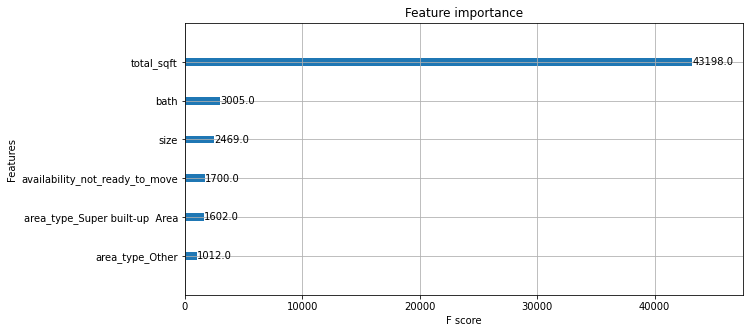

In [42]:
fig = plt.figure(figsize= (10,5))
ax = fig.add_subplot(1,1,1)
xgb.plot_importance(best_reg, ax=ax)

**total_sqft is by far the most important predictor for price**